## General instructions

1) Create a docker container using the image `waikatodatamining/mmsegmentation:1.2.2_cuda11.3` from docker hub which has `mmsegmentation` correctly setup.
2)
   a. For setting it up on Google Colab use the python library `udocker` and follow instructions by Sonny for setup ([Google Colab example](https://colab.research.google.com/drive/1wu6KD2aJ2zqgP0G1Z2-A0_p-kspbtAeT?usp=sharing)).

   b. For setting up locally, create container, install jupyter within container and launch it using below commands.
```bash
# For local setup, adjust shared memory size (shm-size) based on your available memory. Docker by default only permits 64MB which is insufficient for this use case.
docker run --gpus all -p8009:8009 --shm-size="128g" --name mmseg -it -v $(pwd):/workspace -w /workspace waikatodatamining/mmsegmentation:1.2.2_cuda11.3 bash
# Now run the jupyter notebook as a background process
nohup jupyter lab --ip=0.0.0.0 --port=8009 --allow-root &
# To obtain jupyter notebook token, use the below command
jupyter lab list
```
3) Once the container is up and running, clone mmsegmentation and copy notebook inside it
```bash
# Clone mmsegmentation inside your workspace
git clone https://github.com/open-mmlab/mmsegmentation.git
cd mmsegmentation
# Copy this notebook inside mmsegmentation directory
cp ~/Downloads/notebook.ipynb .
```
4) Install `mmdet` as it is required by [Mask2Former](https://github.com/open-mmlab/mmsegmentation/issues/3361).
```bash
pip install "mmdet>=3.0.0rc4"
```

## Import libraries

In [1]:
import argparse
import json
import logging
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import re
import subprocess
import warnings

from mim import download
from mmengine.config import Config
from mmengine.logging import MMLogger
from mmengine.model.utils import revert_sync_batchnorm
from mmseg.apis import init_model, inference_model, show_result_pyplot, MMSegInferencer
from tools.analysis_tools.get_flops import inference, parse_args
from tqdm import tqdm

# Set warnings to ignore UserWarning otherwise mmseg displays many deprecation warnings
logger = MMLogger.get_instance(name='MMLogger')
logger.setLevel(logging.CRITICAL)
warnings.filterwarnings('ignore', category=UserWarning)

## Load Sydneyscapes dataset

1) `mmsegmentation` does not support Sydneyscape but since Sydneyscape follows similar structure and annotation as cityscape, we can use CityScapes API to load SydneyScapes datataset.
2) First download the [Sydneyscapes](https://ses.library.usyd.edu.au/handle/2123/33051) dataset.

In [9]:
!mkdir -p data/sydneyscapes
!wget "https://ses.library.usyd.edu.au/bitstream/handle/2123/33051/sydneyscapes.zip?sequence=1&isAllowed=y" -O "data/sydneyscapes/sydneyscapes.zip" --user-agent="Mozilla/5.0 (Windows NT 10.0; WOW64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/51.0.2704.103 Safari/537.36"

--2025-03-29 05:59:19--  https://ses.library.usyd.edu.au/bitstream/handle/2123/33051/sydneyscapes.zip?sequence=1&isAllowed=y
Resolving ses.library.usyd.edu.au (ses.library.usyd.edu.au)... 104.18.9.195, 104.18.8.195, 2606:4700::6812:8c3, ...
Connecting to ses.library.usyd.edu.au (ses.library.usyd.edu.au)|104.18.9.195|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [application/octet-stream]
Saving to: ‘data/sydneyscapes/sydneyscapes.zip’

data/sydneyscapes/s     [        <=>         ]   1.27G   250MB/s    in 5.2s    

2025-03-29 05:59:25 (252 MB/s) - ‘data/sydneyscapes/sydneyscapes.zip’ saved [1360474511]



In [7]:
!apt-get update
!apt-get install unzip

Get:1 http://security.ubuntu.com/ubuntu bionic-security InRelease [102 kB]
Get:2 http://archive.ubuntu.com/ubuntu bionic InRelease [242 kB]               
Get:3 http://security.ubuntu.com/ubuntu bionic-security/universe amd64 Packages [1637 kB]
Get:4 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [102 kB]       
Get:5 http://archive.ubuntu.com/ubuntu bionic-backports InRelease [102 kB]     
Get:6 http://security.ubuntu.com/ubuntu bionic-security/restricted amd64 Packages [1688 kB]
Get:7 http://security.ubuntu.com/ubuntu bionic-security/multiverse amd64 Packages [23.8 kB]
Get:8 http://security.ubuntu.com/ubuntu bionic-security/main amd64 Packages [3373 kB]
Get:9 http://archive.ubuntu.com/ubuntu bionic/multiverse amd64 Packages [186 kB]
Get:10 http://archive.ubuntu.com/ubuntu bionic/main amd64 Packages [1344 kB]   
Get:11 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease [1581 B]
Get:12 http://archive.ubuntu.com/ubuntu bionic/restricted amd6

In [10]:
!unzip data/sydneyscapes/sydneyscapes.zip -d data/sydneyscapes
!mv data/sydneyscapes/sydneyscapes/* data/sydneyscapes/
!rmdir data/sydneyscapes/sydneyscapes

Archive:  data/sydneyscapes/sydneyscapes.zip
   creating: data/sydneyscapes/sydneyscapes/
   creating: data/sydneyscapes/sydneyscapes/gtFine/
   creating: data/sydneyscapes/sydneyscapes/gtFine/train/
   creating: data/sydneyscapes/sydneyscapes/gtFine/train/NSWday/
  inflating: data/sydneyscapes/sydneyscapes/gtFine/train/NSWday/NSWday_000000_734028_gtFine_color.png  
  inflating: data/sydneyscapes/sydneyscapes/gtFine/train/NSWday/NSWday_000000_734028_gtFine_labelTrainIds.png  
  inflating: data/sydneyscapes/sydneyscapes/gtFine/train/NSWday/NSWday_000000_734028_gtFine_labelIds.png  
  inflating: data/sydneyscapes/sydneyscapes/gtFine/train/NSWday/NSWday_000000_734028_gtFine_instanceIds.png  
  inflating: data/sydneyscapes/sydneyscapes/gtFine/train/NSWday/NSWday_000006_521959_gtFine_labelTrainIds.png  
  inflating: data/sydneyscapes/sydneyscapes/gtFine/train/NSWday/NSWday_000006_521959_gtFine_labelIds.png  
  inflating: data/sydneyscapes/sydneyscapes/gtFine/train/NSWday/NSWday_000006_52195

In [13]:
from mmseg.datasets import CityscapesDataset
from mmengine.registry import init_default_scope
init_default_scope('mmseg')

data_root = 'data/sydneyscapes'
data_prefix=dict(img_path='leftImg8bit/val', seg_map_path='gtFine/val')
test_pipeline = [
    dict(type='LoadImageFromFile'),
    dict(type='LoadAnnotations'),
    dict(type='RandomCrop', crop_size=(512, 1024), cat_max_ratio=0.75),
    dict(type='RandomFlip', prob=0.5),
    dict(type='PackSegInputs')
]

dataset = CityscapesDataset(data_root=data_root, data_prefix=data_prefix, test_mode=True, pipeline=test_pipeline)

Total images in dataset: 152


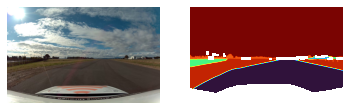

In [14]:
import numpy as np
import matplotlib.image as mpimg

plt.rcParams['figure.dpi'] = 300

print(f'Total images in dataset: {len(dataset)}')
index = 0
img = mpimg.imread(dataset[index]['data_samples'].img_path)
seg = mpimg.imread(dataset[index]['data_samples'].seg_map_path)
seg[seg==1] = np.nan # mask background segments, imread loads values between 0 to 1

fig, axes = plt.subplots(1, 2)

axes[0].imshow(img)
axes[0].axis('off')
axes[1].imshow(seg, cmap='turbo')
axes[1].axis('off')

plt.show()

## View and download checkpoints

In [80]:
# models is a list of model name checkpoints
models = MMSegInferencer.list_models('mmseg')

In [2]:
checkpoints = [
    'pidnet-s_2xb6-120k_1024x1024-cityscapes',
    'pidnet-m_2xb6-120k_1024x1024-cityscapes',
    'pidnet-l_2xb6-120k_1024x1024-cityscapes',
    # 'pspnet_r18-d8_4xb2-80k_cityscapes-512x1024',
    # 'pspnet_r50-d8_4xb2-80k_cityscapes-512x1024',
    # 'pspnet_r101-d8_4xb2-80k_cityscapes-512x1024',
    'bisenetv2_fcn_4xb4-ohem-160k_cityscapes-1024x1024',
    'bisenetv2_fcn_4xb8-160k_cityscapes-1024x1024',
    'bisenetv2_fcn_4xb4-amp-160k_cityscapes-1024x1024',
    'segformer_mit-b0_8xb1-160k_cityscapes-1024x1024',
    'segformer_mit-b1_8xb1-160k_cityscapes-1024x1024',
    'segformer_mit-b2_8xb1-160k_cityscapes-1024x1024',
    'ddrnet_23-slim_in1k-pre_2xb6-120k_cityscapes-1024x1024',
    'ddrnet_23_in1k-pre_2xb6-120k_cityscapes-1024x1024',
    'mask2former_r101_8xb2-90k_cityscapes-512x1024',
    'mask2former_swin-b-in22k-384x384-pre_8xb2-90k_cityscapes-512x1024',
    'mask2former_swin-l-in22k-384x384-pre_8xb2-90k_cityscapes-512x1024',
    'stdc1_4xb12-80k_cityscapes-512x1024',
    'stdc1_in1k-pre_4xb12-80k_cityscapes-512x1024',
    'stdc2_in1k-pre_4xb12-80k_cityscapes-512x1024'

    ## Below models were initially evaluated but left out as not efficient
    # # 'mobilenet-v2-d8_fcn_4xb2-80k_cityscapes-512x1024',
    # # 'mobilenet-v2-d8_pspnet_4xb2-80k_cityscapes-512x1024',
    # # 'mobilenet-v2-d8_deeplabv3_4xb2-80k_cityscapes-512x1024',
    # # 'mobilenet-v2-d8_deeplabv3plus_4xb2-80k_cityscapes-512x1024',
    # # 'setr_vit-l_naive_8xb1-80k_cityscapes-768x768',
    # # 'setr_vit-l_pup_8xb1-80k_cityscapes-768x768',
    # # 'setr_vit-l_mla_8xb1-80k_cityscapes-768x768',
    # # 'ocrnet_hr18s_4xb2-160k_cityscapes-512x1024',
    # # 'ocrnet_hr18_4xb2-160k_cityscapes-512x1024',
    # # 'ocrnet_hr48_4xb2-160k_cityscapes-512x1024',
]

In [3]:
checkpoints_dir = 'checkpoints'
pth_filenames = download('mmsegmentation', checkpoints, dest_root=checkpoints_dir)
pth_filenames = [
    os.path.join(checkpoints_dir, pth_filename)
    for pth_filename in pth_filenames
]
config_filenames = [
    os.path.join(checkpoints_dir, f'{ckpt}.py')
    for ckpt in checkpoints
]

# Save checkpoint and config in a JSON file
config_json = dict()
for conf, pth in zip(config_filenames, pth_filenames):
    config_json[conf] = pth

# No need to save again as city scape notebook saved it.
# with open('config_list.json', 'w') as json_file:
#     json.dump(config_json, json_file, indent=4)

processing pidnet-s_2xb6-120k_1024x1024-cityscapes...
pidnet-s_2xb6-120k_1024x1024-cityscapes_20230302_191700-bb8e3bcc.pth exists in /workspace/mmsegmentation/checkpoints
Successfully dumped pidnet-s_2xb6-120k_1024x1024-cityscapes.py to /workspace/mmsegmentation/checkpoints
processing pidnet-m_2xb6-120k_1024x1024-cityscapes...
pidnet-m_2xb6-120k_1024x1024-cityscapes_20230301_143452-f9bcdbf3.pth exists in /workspace/mmsegmentation/checkpoints
Successfully dumped pidnet-m_2xb6-120k_1024x1024-cityscapes.py to /workspace/mmsegmentation/checkpoints
processing pidnet-l_2xb6-120k_1024x1024-cityscapes...
pidnet-l_2xb6-120k_1024x1024-cityscapes_20230303_114514-0783ca6b.pth exists in /workspace/mmsegmentation/checkpoints
Successfully dumped pidnet-l_2xb6-120k_1024x1024-cityscapes.py to /workspace/mmsegmentation/checkpoints
processing bisenetv2_fcn_4xb4-ohem-160k_cityscapes-1024x1024...
bisenetv2_fcn_ohem_4x4_1024x1024_160k_cityscapes_20210902_112947-5f8103b4.pth exists in /workspace/mmsegmentati

## Evaluation
* Performance (IoU, Pixel accuracy)
* Time taken for each image
* FPS
* Computational power (in GFLOPS), number of params

In [4]:
def extract_model_name(path):
    # Use regex to find the model name
    match = re.search(r'([^/]+?)(?=_[0-9])', path)
    if match:
        return match.group(1)
    else:
        # Return the basename without extension if no match is found
        return os.path.splitext(os.path.basename(path))[0]

def estimate_flops(config_file, input_shape=[2048, 1024]):
    '''
    `mmseg` provides a command line tool in `tools/analysis_tools/get_flops.py` which we
    run using this method for modularity.

    Returns a dict containing `flops` and `params`.
    '''
    args = argparse.Namespace(
        config=config_file,
        shape=input_shape,
        cfg_options=None
    )    
    return inference(args, logger)

def estimate_fps(config_path, checkpoint_path):
    command = [
        'python', 'tools/analysis_tools/benchmark.py', config_path, checkpoint_path,
        '--log-interval', '50', '--work-dir', 'result/benchmark', '--repeat-times', '1'
    ]

    # Run the command using subprocess and capture the output
    result = subprocess.run(command, capture_output=True, text=True)
    out_logs = result.stdout
    fps_pattern = re.compile(r'Average fps of \d+ evaluations:\s*([\d.]+)')

    # Search for the pattern in the out_logs
    match = fps_pattern.search(out_logs)
    if match:
        fps = float(match.group(1))
        return fps
    else:
        return None

In [6]:
def extract_metrics(out_logs):
    # Define regex patterns
    class_pattern = re.compile(r'\|\s+(\w[\w\s]*)\s+\|\s+([\d.]+)\s+\|\s+([\d.]+)\s+\|')
    metric_pattern = re.compile(r'Iter\(test\) \[\d+/\d+\]\s+aAcc:\s*([\d.]+)\s*mIoU:\s*([\d.]+)\s*mAcc:\s*([\d.]+)\s*data_time:\s*([\d.]+)\s*time:\s*([\d.]+)')

    # Initialize dictionaries
    class_metrics = {}
    overall_metrics = {}

    # Extract class-based IoU values
    for match in class_pattern.finditer(out_logs):
        class_name, iou, acc = match.groups()
        class_metrics[class_name.strip()] = {'IoU': float(iou), 'Acc': float(acc)}

    # Extract metrics
    match = metric_pattern.search(out_logs)
    if match:
        aAcc, mIoU, mAcc, data_time, time = match.groups()
        overall_metrics = {
            'aAcc': float(aAcc),
            'mIoU': float(mIoU),
            'mAcc': float(mAcc),
            'data_time': float(data_time),
            'time': float(time)
        }

    return class_metrics, overall_metrics

def call_test_script(config_path, checkpoint_path, extra_options=dict(), input_shape=[2048, 1024]):
    '''
    Returns class based metrics: IoU and pixel accuracy.
    Returns global metrics: mIoU, mean pixel accuracy, average pixel accuracy, time taken.
    Returns additional metrics: flops, params, fps
    '''
    # Derive the output directory from the config path filename
    config_filename = os.path.basename(config_path)
    output_dir = 'result/' + extract_model_name(config_path)

    print('Estimating model accuracy')
    command = [
        'python', 'tools/test.py', config_path, checkpoint_path,
        '--out', output_dir + '_sydneyscapes'
    ]
    if extra_options:
        command += ['--cfg-options']
        for k, v in extra_options.items():
            command += [f'{k}={v}']

    # Run the command using subprocess and capture the output
    result = subprocess.run(command, capture_output=True, text=True)

    # Print the output in Jupyter cell
    # print(result.stdout)
    # print(result.stderr)

    # Store the output in a variable
    out_logs = result.stdout #+ result.stderr

    # Extract metrics from logs
    class_metrics, global_metrics = extract_metrics(out_logs)

    # Additional metrics
    print('Estimating model computational requirements')
    try:
        flops_data = estimate_flops(config_file)
        global_metrics['FLOPS'] = flops_data['flops']
        global_metrics['Params'] = flops_data['params']
        global_metrics['FPS'] = estimate_fps(config_file, checkpoint_file)
    except Exception as e:
        pass # Additional metrics not supported for this model

    # Return the output logs
    return class_metrics, global_metrics

def create_sc_config_file(config_file):
    cfg = Config.fromfile(config_file)
    cfg.data_root = 'data/sydneyscapes/'
    
    # NOTE: must use complete pipeline
    for i, transform in enumerate(cfg.test_pipeline):
        for k, v in transform.items():
            if v == (2048, 1024):
                cfg.test_pipeline[i][k] = (1920, 1208)
    
    # NOTE: add val_dataloader
    cfg.val_dataloader['dataset'].update(dict(
        data_root = cfg.data_root,
        pipeline = cfg.test_pipeline
    ))
    
    cfg.test_dataloader = cfg.val_dataloader
    # Save configuration and load
    sc_config_file = config_file.replace('cityscapes', 'sydneyscapes')
    cfg.dump(sc_config_file)

    return sc_config_file

In [ ]:
# !python tools/test.py \
#     checkpoints/segformer_mit-b0_8xb1-160k_sydneyscapes-1024x1024.py \
#     checkpoints/segformer_mit-b0_8x1_1024x1024_160k_cityscapes_20211208_101857-e7f88502.pth \
#     --out result/segformer_mit-b0

In [ ]:
class_dict = dict()
global_dict = dict()

for config_file, checkpoint_file in tqdm(config_json.items(), desc='Models evaluated'):
    class_metrics, global_metrics = call_test_script(
        create_sc_config_file(config_file),
        checkpoint_file,
        input_shape=[1920, 1208]
    )
    
    model_name = extract_model_name(config_file)
    class_dict[model_name] = class_metrics
    global_dict[model_name] = global_metrics

Models evaluated:   0%|          | 0/17 [00:00<?, ?it/s]

Estimating model accuracy
Estimating model computational requirements


Models evaluated:   6%|▌         | 1/17 [03:24<54:39, 204.98s/it]

Estimating model accuracy
Estimating model computational requirements


Models evaluated:  12%|█▏        | 2/17 [14:38<2:00:13, 480.87s/it]

Estimating model accuracy
Estimating model computational requirements


Models evaluated:  18%|█▊        | 3/17 [27:58<2:26:07, 626.25s/it]

Estimating model accuracy
Estimating model computational requirements


Models evaluated:  24%|██▎       | 4/17 [28:08<1:22:58, 382.98s/it]

Estimating model accuracy
Estimating model computational requirements


Models evaluated:  29%|██▉       | 5/17 [36:15<1:24:06, 420.50s/it]

Estimating model accuracy
Estimating model computational requirements


Models evaluated:  35%|███▌      | 6/17 [44:41<1:22:26, 449.65s/it]

Estimating model accuracy


In [11]:
# get data frame from class metrics dictionary
classes = set()
for model in class_dict.values():
    classes.update(model.keys())

# Create a DataFrame with multi-level columns
columns = pd.MultiIndex.from_product([class_dict.keys(), ['IoU', 'Acc']], names=['Model', 'Metric'])
class_df = pd.DataFrame(index=list(classes), columns=columns)

# Populate the DataFrame with class_dict
for model_name, metrics in class_dict.items():
    for class_name, values in metrics.items():
        class_df.loc[class_name, (model_name, 'IoU')] = values['IoU']
        class_df.loc[class_name, (model_name, 'Acc')] = values['Acc']

# Display the DataFrame
class_df = class_df.T
class_df.to_csv('result/class_metrics_sydneyscapes.csv')
class_df

fence    car person building  \
Model                                Metric                                 
pidnet-s                             IoU     30.36  65.87  66.26    74.11   
                                     Acc      42.6  82.84  89.07    91.87   
pidnet-m                             IoU     35.56  67.34  69.09    75.03   
                                     Acc     40.09   84.9  89.41     93.4   
pidnet-l                             IoU     33.48  66.51  73.08    75.59   
                                     Acc     41.75  85.77  86.91     87.2   
bisenetv2_fcn                        IoU     26.71  48.49   53.6    68.75   
                                     Acc     35.67  79.09  89.01     84.4   
segformer_mit-b0                     IoU      27.6   71.8   72.1    74.72   
                                     Acc     39.96  82.19  85.64    94.94   
segformer_mit-b1                     IoU     34.45  72.95  73.21    75.16   
                                     Acc     40.36  85.97  86.92    94.79   
segformer_mit-b2                     IoU     37.12  72.28  74.46     78.8   
                                     Acc     41.73  87.24  87.81    92.53   
ddrnet                               IoU     32.23  63.77  67.51    68.71   
                                     Acc     34.83  73.22  89.88    86.03   
mask2former_r101                     IoU     26.51  59.58  76.14    76.48   
                                     Acc      37.6  87.04   86.3    89.77   
mask2former_swin-b-in22k-384x384-pre IoU     48.96  84.04  80.06    87.18   
                                     Acc     57.98  95.74  91.66    93.84   
mask2former_swin-l-in22k-384x384-pre IoU     49.26  84.69  81.85    89.17   
                                     Acc     56.65  95.91   91.9    94.03   
stdc1                                IoU     23.42  46.34  53.14    65.99   
                                     Acc      31.4  75.26  86.19    83.34   
stdc1_in1k-pre                       IoU     23.09  47.57   59.8    58.18   
                                     Acc     25.98  72.67  85.03     90.1   
stdc2_in1k-pre                       IoU     33.94  57.53  64.12    67.64   
                                     Acc     44.06  80.46  86.54    89.53   

                                               sky   pole traffic sign  \
Model                                Metric                              
pidnet-s                             IoU     82.12  34.63        29.04   
                                     Acc     83.04  39.75        32.18   
pidnet-m                             IoU     85.36   38.4        32.38   
                                     Acc     86.17  44.99        36.04   
pidnet-l                             IoU      79.8  39.79        31.96   
                                     Acc      80.7  45.32        37.97   
bisenetv2_fcn                        IoU     74.45   32.1        26.33   
                                     Acc     75.57  37.42        32.39   
segformer_mit-b0                     IoU     86.08   39.3        35.02   
                                     Acc      86.8  46.27        38.83   
segformer_mit-b1                     IoU     88.78  44.19        41.63   
                                     Acc     89.45  52.66        49.84   
segformer_mit-b2                     IoU     90.64  43.46        46.61   
                                     Acc     91.28  50.55        52.19   
ddrnet                               IoU     79.22  35.91        29.24   
                                     Acc     79.86  40.49        31.61   
mask2former_r101                     IoU     88.38  43.67        25.05   
                                     Acc     89.13   52.6        45.41   
mask2former_swin-b-in22k-384x384-pre IoU     94.91  50.99        54.48   
                                     Acc     95.59  60.36        62.38   
mask2former_swin-l-in22k-384x384-pre IoU      96.1  57.32         58.7   
                                

In [10]:
global_df = pd.DataFrame(global_dict).T
class_df.to_csv('result/global_metrics_sydneyscapes.csv')
global_df

,aAcc,mIoU,mAcc,data_time,time,FLOPS,Params,FPS
pidnet-s,82.44,45.96,60.09,0.0212,0.4504,47.517G,7.721M,1.7
pidnet-m,84.77,49.52,62.3,0.0397,1.878,0.178T,28.763M,0.56
pidnet-l,83.06,47.62,63.12,0.0412,2.4205,0.276T,37.314M,0.5
bisenetv2_fcn,77.6,37.67,51.46,0.0458,1.4823,98.854G,3.359M,0.79
segformer_mit-b0,85.04,49.94,60.73,0.0412,10.9065,0.122T,3.72M,0.18
segformer_mit-b1,85.82,52.66,65.13,0.0395,12.7975,0.24T,13.683M,0.14
segformer_mit-b2,87.71,54.64,66.18,0.0403,21.1499,0.421T,24.728M,0.16
ddrnet,80.16,43.75,55.87,0.0282,0.7213,0.144T,20.299M,1.61
mask2former_r101,84.98,47.08,65.91,0.0276,8.5791,NaN,NaN,NaN
mask2former_swin-b-in22k-384x384-pre,92.37,65.07,79.84,0.0267,11.2851,NaN,NaN,NaN


## Command line equivalent
`no need to run`

In [14]:
# !python tools/test.py \
#     configs/segformer/segformer_mit-b0_8xb1-160k_cityscapes-1024x1024.py \
#     checkpoints/segformer_mit-b0_8x1_1024x1024_160k_cityscapes_20211208_101857-e7f88502.pth \
#     --out result/segformerb0_result

# !python tools/analysis_tools/benchmark.py \
#     configs/segformer/segformer_mit-b0_8xb1-160k_cityscapes-1024x1024.py \
#     checkpoints/segformer_mit-b0_8x1_1024x1024_160k_cityscapes_20211208_101857-e7f88502.pth \
#     --log-interval 50 \
#     --work-dir result/benchmark \
#     --repeat-times 1

Run 1:
/mmsegmentation/mmseg/models/builder.py:36: UserWarning: ``build_loss`` would be deprecated soon, please use ``mmseg.registry.MODELS.build()`` 
  warnings.warn('``build_loss`` would be deprecated soon, please use '
/mmsegmentation/mmseg/models/losses/cross_entropy_loss.py:250: UserWarning: Default ``avg_non_ignore`` is False, if you would like to ignore the certain label and average loss over non-ignore labels, which is the same with PyTorch official cross_entropy, set ``avg_non_ignore=True``.
  warnings.warn(
Loads checkpoint by local backend from path: checkpoints/segformer_mit-b0_8x1_1024x1024_160k_cityscapes_20211208_101857-e7f88502.pth
Done image [50 / 200], fps: 22.51 img / s
Done image [100/ 200], fps: 22.52 img / s
Done image [150/ 200], fps: 22.53 img / s
Done image [200/ 200], fps: 22.53 img / s
Overall fps: 22.53 img / s

Average fps of 1 evaluations: 22.53
The variance of 1 evaluations: 0.0


In [11]:
# !rm -r result/segformerb0_result/.ipynb_checkpoints/

In [12]:
!python tools/analysis_tools/confusion_matrix.py \
    configs/segformer/segformer_mit-b0_8xb1-160k_cityscapes-1024x1024.py \
    result/segformerb0_result \
    result/confusion_matrix --show

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 500/500, 20.0 task/s, elapsed: 25s, ETA:     0stools/analysis_tools/confusion_matrix.py:100: RuntimeWarning: invalid value encountered in true_divide
  confusion_matrix.astype(np.float32) / per_label_sums * 100
Figure(11400x9120)


## Exploring the dataset

In [24]:
import os
import shutil
from mmseg.evaluation.metrics import CityscapesMetric

run_dir = '../evaluation'
run_index = '1'
run_path = os.path.join(run_dir, run_index)

if os.path.exists(run_path):
    shutil.rmtree(run_path)
os.makedirs(run_path)

metric = CityscapesMetric(output_dir=run_path, ignore_index=255, format_only=False, keep_results=True, collect_device='cpu', prefix=None)

03/26 05:12:55 - mmengine - WARNING - The prefix is not set in metric class CityscapesMetric.


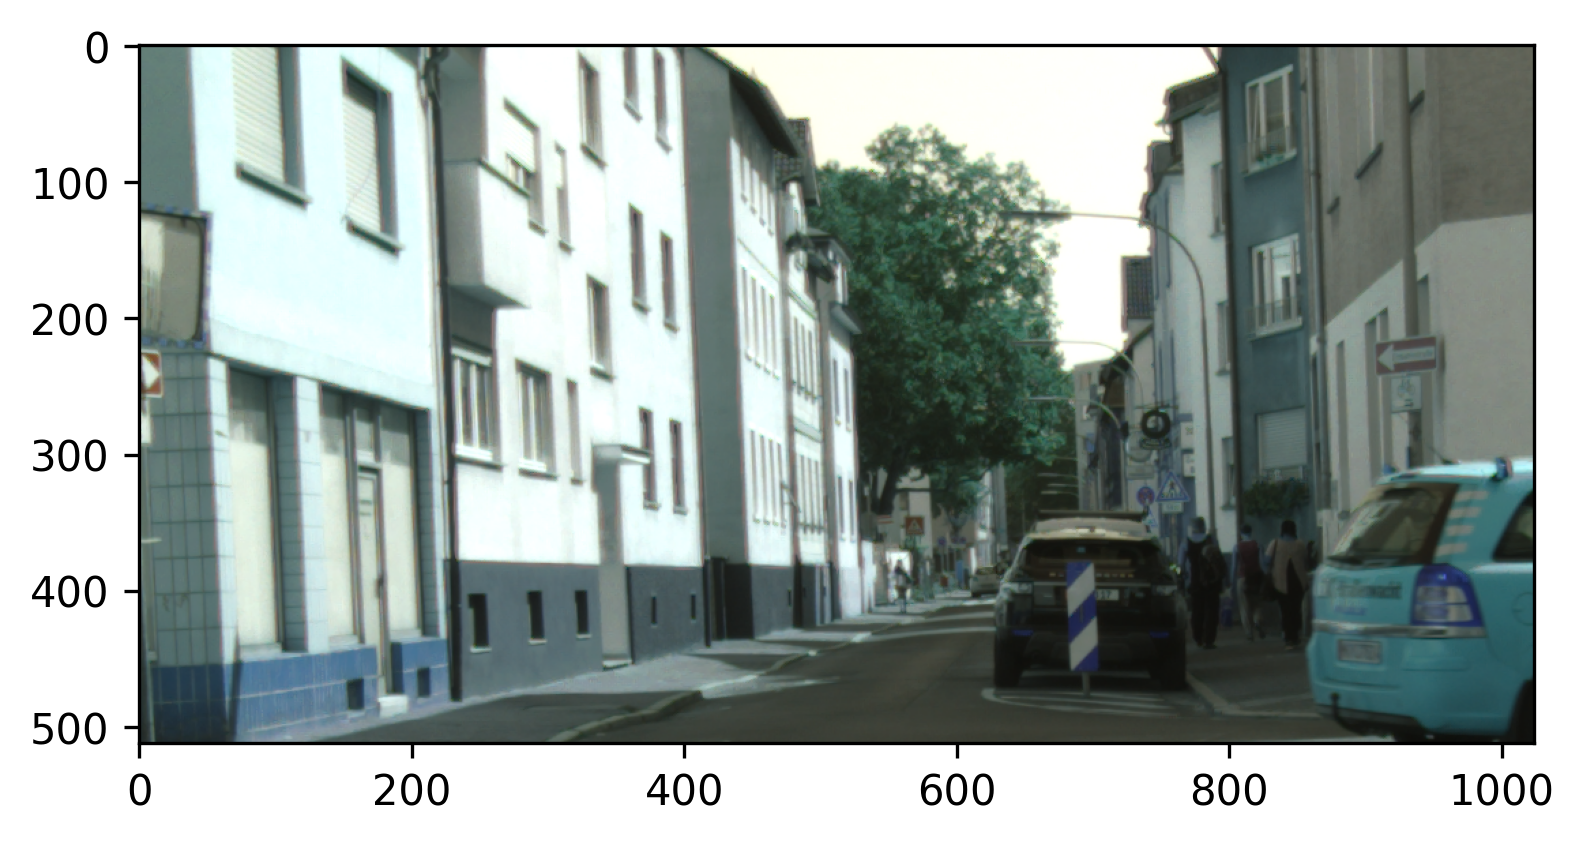

In [93]:
row = dataset[0]
img = np.array(row['inputs'])
img = np.transpose(img, (1, 2, 0))
plt.imshow(img, cmap='turbo')

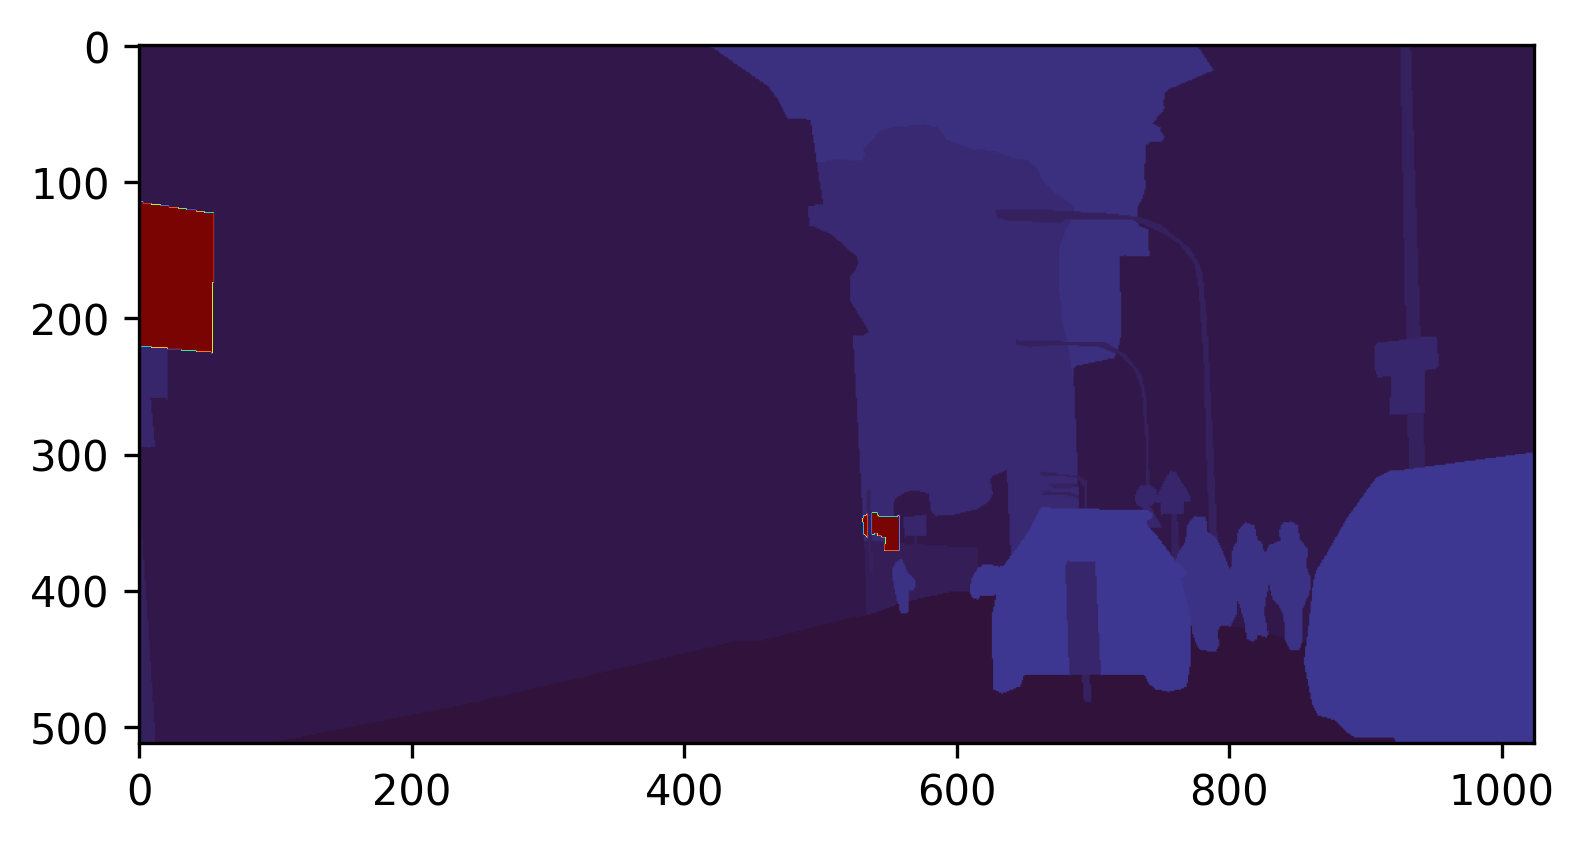

In [95]:
seg = np.array(row['data_samples'].gt_sem_seg.data.squeeze(0))
seg[seg==1] = 0 # mask background segments, imread loads values between 0 to 1
plt.imshow(seg, cmap='turbo')

In [26]:
for row in len(dataset):
    row = dataset[0]
    img = np.array(row['inputs'])
    img = mpimg.imread(row['data_samples'].img_path)
    seg = mpimg.imread(row['data_samples'].seg_map_path)
    seg[seg==1] = np.nan # mask background segments, imread loads values between 0 to 1
    

Help on method compute_metrics in module mmseg.evaluation.metrics.citys_metric:

compute_metrics(results: list) -> Dict[str, float] method of mmseg.evaluation.metrics.citys_metric.CityscapesMetric instance
    Compute the metrics from processed results.
    
    Args:
        results (list): Testing results of the dataset.
    
    Returns:
        dict[str: float]: Cityscapes evaluation results.

